# Generative Adversarial Network(GAN)


https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)


In [0]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dens

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
___________________________

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def plot_generated_images(epoch, generator, examples=4, dim=(2,2), figsize=(5,5)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='binary')
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig('gan_generated_image %d.png' %epoch)

In [0]:
import numpy as np
from IPython.display import SVG, display
from PIL import Image

def invert_image(img):
    return( np.invert(img)  )

  
def denomalize_image(img, invert=False):
    if img.dtype is np.dtype(np.float32):
      image = img * 255
      image = image.astype('uint8')
    else:
      image = img
    
    if invert == True:
      image = invert_image( image )

    return( image )
    

def init_display(img, zoom=2):
    height, width = img.shape
    img_array=denomalize_image(img, invert=True)
    img_disp = Image.fromarray(img_array,mode='P')
    if zoom == 1:
      out = display(img_disp, display_id=True)
    else:
      out = display(img_disp.resize((width*zoom,height*zoom)), display_id=True)
    return( out )


def update_display(out, img, zoom=2):
    height, width = img.shape
    img_array=denomalize_image(img, invert=True)
    img_disp = Image.fromarray(img_array,mode='P')
    if zoom == 1:
      out.update(img_disp)
    else:
      out.update(img_disp.resize((width*zoom,height*zoom)))


      
def plot_output( epoch, generator, examples=16, initial=False, out=None ):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    plot_image = np.concatenate(generated_images, axis = 1)
    if initial == False:
      update_display(out, plot_image)
    else:
      output = init_display(plot_image)
      return( output )
    

def plot_sample( sample ):
    plot_image = np.concatenate(sample.reshape(sample.shape[0],28,28), axis = 1)
    output = init_display(plot_image)
    return( output )
        
    
    

In [0]:
def training(epochs=1, batch_size=128, sample_size=10):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    #Pick the sample images
    sample = np.empty(shape=10).astype('uint8')
    for i in range(0,10):
      sample[i] = np.where(y_train==i)[0][5]
    
    sample_image = X_train[sample]
    plot_sample( sample_image )
    
    #Display the initial generator generated images
    display_output = plot_output( 0, generator, examples=16, initial=True )

    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            #image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            #image_batch = X_train[0:batch_size,:]
            image_batch = X_train[np.random.choice(sample, size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:sample_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 2 == 0:
            #plot_generated_images(e, generator)
            plot_output( e, generator, out=display_output )
              


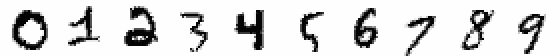

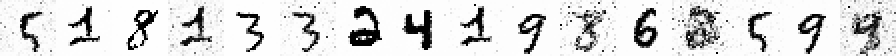

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1


 12%|█▎        | 8/64 [00:00<00:00, 77.14it/s]

Epoch 2


 12%|█▎        | 8/64 [00:00<00:00, 77.47it/s]

Epoch 3


 12%|█▎        | 8/64 [00:00<00:00, 79.88it/s]

Epoch 4


 12%|█▎        | 8/64 [00:00<00:00, 75.49it/s]

Epoch 5


 12%|█▎        | 8/64 [00:00<00:00, 79.76it/s]

Epoch 6


 12%|█▎        | 8/64 [00:00<00:00, 76.79it/s]

Epoch 7


 14%|█▍        | 9/64 [00:00<00:00, 80.96it/s]

Epoch 8


 12%|█▎        | 8/64 [00:00<00:00, 76.70it/s]

Epoch 9


 12%|█▎        | 8/64 [00:00<00:00, 79.46it/s]

Epoch 10


 12%|█▎        | 8/64 [00:00<00:00, 75.19it/s]

Epoch 11


 12%|█▎        | 8/64 [00:00<00:00, 79.77it/s]

Epoch 12


 12%|█▎        | 8/64 [00:00<00:00, 71.30it/s]

Epoch 13


 14%|█▍        | 9/64 [00:00<00:00, 81.11it/s]

Epoch 14


 14%|█▍        | 9/64 [00:00<00:00, 80.56it/s]

Epoch 15


 14%|█▍        | 9/64 [00:00<00:00, 81.32it/s]

Epoch 16


 11%|█         | 7/64 [00:00<00:00, 68.42it/s]

Epoch 17


 12%|█▎        | 8/64 [00:00<00:00, 71.59it/s]

Epoch 18


  9%|▉         | 6/64 [00:00<00:00, 59.92it/s]

Epoch 19


 12%|█▎        | 8/64 [00:00<00:00, 70.58it/s]

Epoch 20


 11%|█         | 7/64 [00:00<00:00, 67.88it/s]

Epoch 21


 12%|█▎        | 8/64 [00:00<00:00, 71.24it/s]

Epoch 22


 11%|█         | 7/64 [00:00<00:00, 67.73it/s]

Epoch 23


 12%|█▎        | 8/64 [00:00<00:00, 72.60it/s]

Epoch 24


 11%|█         | 7/64 [00:00<00:00, 65.87it/s]

Epoch 25


 12%|█▎        | 8/64 [00:00<00:00, 71.74it/s]

Epoch 26


 11%|█         | 7/64 [00:00<00:00, 66.13it/s]

Epoch 27


 12%|█▎        | 8/64 [00:00<00:00, 77.69it/s]

Epoch 28


 12%|█▎        | 8/64 [00:00<00:00, 76.60it/s]

Epoch 29


 14%|█▍        | 9/64 [00:00<00:00, 80.96it/s]

Epoch 30


 12%|█▎        | 8/64 [00:00<00:00, 76.43it/s]

Epoch 31


 14%|█▍        | 9/64 [00:00<00:00, 81.56it/s]

Epoch 32


 12%|█▎        | 8/64 [00:00<00:00, 78.98it/s]

Epoch 33


 14%|█▍        | 9/64 [00:00<00:00, 80.27it/s]

Epoch 34


 12%|█▎        | 8/64 [00:00<00:00, 77.36it/s]

Epoch 35


 12%|█▎        | 8/64 [00:00<00:00, 79.99it/s]

Epoch 36


 12%|█▎        | 8/64 [00:00<00:00, 77.93it/s]

Epoch 37


 12%|█▎        | 8/64 [00:00<00:00, 79.38it/s]

Epoch 38


 12%|█▎        | 8/64 [00:00<00:00, 76.58it/s]

Epoch 39


 12%|█▎        | 8/64 [00:00<00:00, 74.07it/s]

Epoch 40


 12%|█▎        | 8/64 [00:00<00:00, 78.61it/s]

Epoch 41


 14%|█▍        | 9/64 [00:00<00:00, 80.89it/s]

Epoch 42


 12%|█▎        | 8/64 [00:00<00:00, 76.87it/s]

Epoch 43


 12%|█▎        | 8/64 [00:00<00:00, 79.61it/s]

Epoch 44


 12%|█▎        | 8/64 [00:00<00:00, 78.32it/s]

Epoch 45


 12%|█▎        | 8/64 [00:00<00:00, 78.57it/s]

Epoch 46


 12%|█▎        | 8/64 [00:00<00:00, 78.45it/s]

Epoch 47


 12%|█▎        | 8/64 [00:00<00:00, 79.16it/s]

Epoch 48


 12%|█▎        | 8/64 [00:00<00:00, 77.30it/s]

Epoch 49


 12%|█▎        | 8/64 [00:00<00:00, 79.48it/s]

Epoch 50


 12%|█▎        | 8/64 [00:00<00:00, 76.02it/s]

Epoch 51


 12%|█▎        | 8/64 [00:00<00:00, 79.64it/s]

Epoch 52


 12%|█▎        | 8/64 [00:00<00:00, 76.19it/s]

Epoch 53


 14%|█▍        | 9/64 [00:00<00:00, 82.72it/s]

Epoch 54


 12%|█▎        | 8/64 [00:00<00:00, 76.41it/s]

Epoch 55


 14%|█▍        | 9/64 [00:00<00:00, 81.67it/s]

Epoch 56


 12%|█▎        | 8/64 [00:00<00:00, 73.94it/s]

Epoch 57


 14%|█▍        | 9/64 [00:00<00:00, 81.13it/s]

Epoch 58


 12%|█▎        | 8/64 [00:00<00:00, 76.86it/s]

Epoch 59


 14%|█▍        | 9/64 [00:00<00:00, 80.77it/s]

Epoch 60


 12%|█▎        | 8/64 [00:00<00:00, 73.20it/s]

Epoch 61


 11%|█         | 7/64 [00:00<00:00, 69.77it/s]

Epoch 62


 11%|█         | 7/64 [00:00<00:00, 67.53it/s]

Epoch 63


 12%|█▎        | 8/64 [00:00<00:00, 70.60it/s]

Epoch 64


 11%|█         | 7/64 [00:00<00:00, 62.51it/s]

Epoch 65


 11%|█         | 7/64 [00:00<00:00, 69.28it/s]

Epoch 66


 12%|█▎        | 8/64 [00:00<00:00, 74.92it/s]

Epoch 67


 14%|█▍        | 9/64 [00:00<00:00, 82.61it/s]

Epoch 68


 12%|█▎        | 8/64 [00:00<00:00, 77.90it/s]

Epoch 69


 12%|█▎        | 8/64 [00:00<00:00, 78.83it/s]

Epoch 70


 12%|█▎        | 8/64 [00:00<00:00, 72.58it/s]

Epoch 71


 14%|█▍        | 9/64 [00:00<00:00, 81.26it/s]

Epoch 72


 12%|█▎        | 8/64 [00:00<00:00, 77.84it/s]

Epoch 73


 14%|█▍        | 9/64 [00:00<00:00, 82.66it/s]

Epoch 74


 12%|█▎        | 8/64 [00:00<00:00, 75.19it/s]

Epoch 75


 12%|█▎        | 8/64 [00:00<00:00, 74.41it/s]

Epoch 76


 12%|█▎        | 8/64 [00:00<00:00, 77.25it/s]

Epoch 77


 12%|█▎        | 8/64 [00:00<00:00, 79.73it/s]

Epoch 78


 12%|█▎        | 8/64 [00:00<00:00, 77.51it/s]

Epoch 79


 14%|█▍        | 9/64 [00:00<00:00, 81.75it/s]

Epoch 80


 12%|█▎        | 8/64 [00:00<00:00, 72.87it/s]

Epoch 81


 14%|█▍        | 9/64 [00:00<00:00, 81.91it/s]

Epoch 82


 12%|█▎        | 8/64 [00:00<00:00, 75.57it/s]

Epoch 83


 14%|█▍        | 9/64 [00:00<00:00, 81.24it/s]

Epoch 84


 14%|█▍        | 9/64 [00:00<00:00, 80.63it/s]

Epoch 85


 12%|█▎        | 8/64 [00:00<00:00, 71.98it/s]

Epoch 86


 12%|█▎        | 8/64 [00:00<00:00, 77.38it/s]

Epoch 87


 14%|█▍        | 9/64 [00:00<00:00, 80.29it/s]

Epoch 88


 12%|█▎        | 8/64 [00:00<00:00, 78.85it/s]

Epoch 89


 14%|█▍        | 9/64 [00:00<00:00, 80.78it/s]

Epoch 90


 12%|█▎        | 8/64 [00:00<00:00, 70.05it/s]

Epoch 91


 14%|█▍        | 9/64 [00:00<00:00, 81.84it/s]

Epoch 92


 12%|█▎        | 8/64 [00:00<00:00, 79.39it/s]

Epoch 93


 14%|█▍        | 9/64 [00:00<00:00, 80.16it/s]

Epoch 94


 12%|█▎        | 8/64 [00:00<00:00, 75.74it/s]

Epoch 95


 14%|█▍        | 9/64 [00:00<00:00, 82.27it/s]

Epoch 96


 12%|█▎        | 8/64 [00:00<00:00, 78.12it/s]

Epoch 97


 14%|█▍        | 9/64 [00:00<00:00, 82.78it/s]

Epoch 98


 12%|█▎        | 8/64 [00:00<00:00, 78.19it/s]

Epoch 99


 14%|█▍        | 9/64 [00:00<00:00, 80.76it/s]

Epoch 100


 12%|█▎        | 8/64 [00:00<00:00, 78.81it/s]

Epoch 101


 14%|█▍        | 9/64 [00:00<00:00, 80.23it/s]

Epoch 102


 14%|█▍        | 9/64 [00:00<00:00, 81.13it/s]

Epoch 103


 12%|█▎        | 8/64 [00:00<00:00, 78.85it/s]

Epoch 104


 12%|█▎        | 8/64 [00:00<00:00, 78.93it/s]

Epoch 105


 14%|█▍        | 9/64 [00:00<00:00, 80.84it/s]

Epoch 106


 12%|█▎        | 8/64 [00:00<00:00, 78.85it/s]

Epoch 107


 12%|█▎        | 8/64 [00:00<00:00, 78.19it/s]

Epoch 108


 14%|█▍        | 9/64 [00:00<00:00, 80.52it/s]

Epoch 109


 11%|█         | 7/64 [00:00<00:00, 67.24it/s]

Epoch 110


 14%|█▍        | 9/64 [00:00<00:00, 80.55it/s]

Epoch 111


 14%|█▍        | 9/64 [00:00<00:00, 81.03it/s]

Epoch 112


 12%|█▎        | 8/64 [00:00<00:00, 73.47it/s]

Epoch 113


 11%|█         | 7/64 [00:00<00:00, 69.72it/s]

Epoch 114


 12%|█▎        | 8/64 [00:00<00:00, 70.71it/s]

Epoch 115


 12%|█▎        | 8/64 [00:00<00:00, 72.05it/s]

Epoch 116


 11%|█         | 7/64 [00:00<00:00, 61.86it/s]

Epoch 117


 12%|█▎        | 8/64 [00:00<00:00, 71.55it/s]

Epoch 118


 11%|█         | 7/64 [00:00<00:00, 68.96it/s]

Epoch 119


 12%|█▎        | 8/64 [00:00<00:00, 71.68it/s]

Epoch 120


 12%|█▎        | 8/64 [00:00<00:00, 70.74it/s]

Epoch 121


 11%|█         | 7/64 [00:00<00:00, 69.41it/s]

Epoch 122


 12%|█▎        | 8/64 [00:00<00:00, 72.12it/s]

Epoch 123


 12%|█▎        | 8/64 [00:00<00:00, 77.15it/s]

Epoch 124


 12%|█▎        | 8/64 [00:00<00:00, 73.01it/s]

Epoch 125


 14%|█▍        | 9/64 [00:00<00:00, 80.83it/s]

Epoch 126


 14%|█▍        | 9/64 [00:00<00:00, 81.59it/s]

Epoch 127


 14%|█▍        | 9/64 [00:00<00:00, 81.70it/s]

Epoch 128


 12%|█▎        | 8/64 [00:00<00:00, 78.12it/s]

Epoch 129


 12%|█▎        | 8/64 [00:00<00:00, 73.99it/s]

Epoch 130


 14%|█▍        | 9/64 [00:00<00:00, 81.34it/s]

Epoch 131


 14%|█▍        | 9/64 [00:00<00:00, 80.34it/s]

Epoch 132


 14%|█▍        | 9/64 [00:00<00:00, 81.55it/s]

Epoch 133


 12%|█▎        | 8/64 [00:00<00:00, 78.75it/s]

Epoch 134


 12%|█▎        | 8/64 [00:00<00:00, 73.02it/s]

Epoch 135


 12%|█▎        | 8/64 [00:00<00:00, 78.77it/s]

Epoch 136


 12%|█▎        | 8/64 [00:00<00:00, 78.11it/s]

Epoch 137


 14%|█▍        | 9/64 [00:00<00:00, 82.77it/s]

Epoch 138


 14%|█▍        | 9/64 [00:00<00:00, 81.78it/s]

Epoch 139


 12%|█▎        | 8/64 [00:00<00:00, 76.18it/s]

Epoch 140


 12%|█▎        | 8/64 [00:00<00:00, 77.99it/s]

Epoch 141


 14%|█▍        | 9/64 [00:00<00:00, 80.82it/s]

Epoch 142


 14%|█▍        | 9/64 [00:00<00:00, 81.24it/s]

Epoch 143


 14%|█▍        | 9/64 [00:00<00:00, 80.97it/s]

Epoch 144


 12%|█▎        | 8/64 [00:00<00:00, 78.54it/s]

Epoch 145


 12%|█▎        | 8/64 [00:00<00:00, 79.90it/s]

Epoch 146


 14%|█▍        | 9/64 [00:00<00:00, 80.82it/s]

Epoch 147


 14%|█▍        | 9/64 [00:00<00:00, 80.90it/s]

Epoch 148


 12%|█▎        | 8/64 [00:00<00:00, 76.56it/s]

Epoch 149


 14%|█▍        | 9/64 [00:00<00:00, 80.96it/s]

Epoch 150


 14%|█▍        | 9/64 [00:00<00:00, 81.88it/s]

Epoch 151


 12%|█▎        | 8/64 [00:00<00:00, 79.96it/s]

Epoch 152


 12%|█▎        | 8/64 [00:00<00:00, 78.93it/s]

Epoch 153


 12%|█▎        | 8/64 [00:00<00:00, 79.74it/s]

Epoch 154


 12%|█▎        | 8/64 [00:00<00:00, 79.45it/s]

Epoch 155


 14%|█▍        | 9/64 [00:00<00:00, 80.70it/s]

Epoch 156


 14%|█▍        | 9/64 [00:00<00:00, 80.94it/s]

Epoch 157


 14%|█▍        | 9/64 [00:00<00:00, 82.29it/s]

Epoch 158


 12%|█▎        | 8/64 [00:00<00:00, 79.42it/s]

Epoch 159


 12%|█▎        | 8/64 [00:00<00:00, 79.61it/s]

Epoch 160


 14%|█▍        | 9/64 [00:00<00:00, 81.90it/s]

Epoch 161


 12%|█▎        | 8/64 [00:00<00:00, 79.11it/s]

Epoch 162


 14%|█▍        | 9/64 [00:00<00:00, 80.75it/s]

Epoch 163


 12%|█▎        | 8/64 [00:00<00:00, 73.57it/s]

Epoch 164


 12%|█▎        | 8/64 [00:00<00:00, 77.80it/s]

Epoch 165


 14%|█▍        | 9/64 [00:00<00:00, 81.45it/s]

Epoch 166


 12%|█▎        | 8/64 [00:00<00:00, 76.96it/s]

Epoch 167


 12%|█▎        | 8/64 [00:00<00:00, 79.59it/s]

Epoch 168


 11%|█         | 7/64 [00:00<00:00, 68.01it/s]

Epoch 169


 14%|█▍        | 9/64 [00:00<00:00, 81.74it/s]

Epoch 170


 12%|█▎        | 8/64 [00:00<00:00, 79.90it/s]

Epoch 171


 14%|█▍        | 9/64 [00:00<00:00, 81.98it/s]

Epoch 172


 12%|█▎        | 8/64 [00:00<00:00, 77.87it/s]

Epoch 173


 12%|█▎        | 8/64 [00:00<00:00, 77.96it/s]

Epoch 174


 12%|█▎        | 8/64 [00:00<00:00, 79.49it/s]

Epoch 175


 14%|█▍        | 9/64 [00:00<00:00, 80.53it/s]

Epoch 176


 14%|█▍        | 9/64 [00:00<00:00, 81.17it/s]

Epoch 177


 14%|█▍        | 9/64 [00:00<00:00, 81.64it/s]

Epoch 178


 12%|█▎        | 8/64 [00:00<00:00, 77.49it/s]

Epoch 179


 12%|█▎        | 8/64 [00:00<00:00, 79.79it/s]

Epoch 180


 12%|█▎        | 8/64 [00:00<00:00, 78.02it/s]

Epoch 181


 14%|█▍        | 9/64 [00:00<00:00, 81.55it/s]

Epoch 182


 12%|█▎        | 8/64 [00:00<00:00, 78.21it/s]

Epoch 183


 14%|█▍        | 9/64 [00:00<00:00, 79.89it/s]

Epoch 184


 12%|█▎        | 8/64 [00:00<00:00, 78.08it/s]

Epoch 185


 14%|█▍        | 9/64 [00:00<00:00, 82.18it/s]

Epoch 186


 12%|█▎        | 8/64 [00:00<00:00, 77.69it/s]

Epoch 187


 14%|█▍        | 9/64 [00:00<00:00, 81.78it/s]

Epoch 188


 12%|█▎        | 8/64 [00:00<00:00, 79.09it/s]

Epoch 189


 14%|█▍        | 9/64 [00:00<00:00, 81.05it/s]

Epoch 190


 14%|█▍        | 9/64 [00:00<00:00, 81.59it/s]

Epoch 191


 14%|█▍        | 9/64 [00:00<00:00, 80.85it/s]

Epoch 192


 12%|█▎        | 8/64 [00:00<00:00, 72.09it/s]

Epoch 193


 14%|█▍        | 9/64 [00:00<00:00, 80.86it/s]

Epoch 194


 12%|█▎        | 8/64 [00:00<00:00, 77.86it/s]

Epoch 195


 14%|█▍        | 9/64 [00:00<00:00, 81.11it/s]

Epoch 196


 12%|█▎        | 8/64 [00:00<00:00, 79.59it/s]

Epoch 197


 12%|█▎        | 8/64 [00:00<00:00, 74.22it/s]

Epoch 198


 14%|█▍        | 9/64 [00:00<00:00, 82.82it/s]

Epoch 199


 14%|█▍        | 9/64 [00:00<00:00, 81.12it/s]

Epoch 200


 12%|█▎        | 8/64 [00:00<00:00, 79.62it/s]

Epoch 201


 14%|█▍        | 9/64 [00:00<00:00, 81.43it/s]

Epoch 202


 12%|█▎        | 8/64 [00:00<00:00, 71.94it/s]

Epoch 203


 14%|█▍        | 9/64 [00:00<00:00, 81.40it/s]

Epoch 204


 12%|█▎        | 8/64 [00:00<00:00, 78.55it/s]

Epoch 205


 14%|█▍        | 9/64 [00:00<00:00, 80.48it/s]

Epoch 206


 12%|█▎        | 8/64 [00:00<00:00, 79.12it/s]

Epoch 207


 12%|█▎        | 8/64 [00:00<00:00, 78.07it/s]

Epoch 208


 12%|█▎        | 8/64 [00:00<00:00, 78.88it/s]

Epoch 209


 14%|█▍        | 9/64 [00:00<00:00, 81.56it/s]

Epoch 210


 12%|█▎        | 8/64 [00:00<00:00, 71.79it/s]

Epoch 211


 12%|█▎        | 8/64 [00:00<00:00, 72.58it/s]

Epoch 212


 11%|█         | 7/64 [00:00<00:00, 68.36it/s]

Epoch 213


 11%|█         | 7/64 [00:00<00:00, 64.67it/s]

Epoch 214


 12%|█▎        | 8/64 [00:00<00:00, 72.41it/s]

Epoch 215


 12%|█▎        | 8/64 [00:00<00:00, 71.07it/s]

Epoch 216


 11%|█         | 7/64 [00:00<00:00, 69.36it/s]

Epoch 217


 12%|█▎        | 8/64 [00:00<00:00, 71.62it/s]

Epoch 218


 11%|█         | 7/64 [00:00<00:00, 67.83it/s]

Epoch 219


 12%|█▎        | 8/64 [00:00<00:00, 71.58it/s]

Epoch 220


 11%|█         | 7/64 [00:00<00:00, 69.54it/s]

Epoch 221


 14%|█▍        | 9/64 [00:00<00:00, 80.59it/s]

Epoch 222


 12%|█▎        | 8/64 [00:00<00:00, 74.96it/s]

Epoch 223


 14%|█▍        | 9/64 [00:00<00:00, 81.02it/s]

Epoch 224


 14%|█▍        | 9/64 [00:00<00:00, 81.31it/s]

Epoch 225


 14%|█▍        | 9/64 [00:00<00:00, 80.68it/s]

Epoch 226


 12%|█▎        | 8/64 [00:00<00:00, 77.67it/s]

Epoch 227


 14%|█▍        | 9/64 [00:00<00:00, 80.51it/s]

Epoch 228


 12%|█▎        | 8/64 [00:00<00:00, 79.04it/s]

Epoch 229


 14%|█▍        | 9/64 [00:00<00:00, 81.84it/s]

Epoch 230


 12%|█▎        | 8/64 [00:00<00:00, 78.08it/s]

Epoch 231


 14%|█▍        | 9/64 [00:00<00:00, 82.15it/s]

Epoch 232


 12%|█▎        | 8/64 [00:00<00:00, 79.24it/s]

Epoch 233


 12%|█▎        | 8/64 [00:00<00:00, 79.59it/s]

Epoch 234


 12%|█▎        | 8/64 [00:00<00:00, 76.33it/s]

Epoch 235


 14%|█▍        | 9/64 [00:00<00:00, 81.40it/s]

Epoch 236


 12%|█▎        | 8/64 [00:00<00:00, 73.55it/s]

Epoch 237


 14%|█▍        | 9/64 [00:00<00:00, 80.44it/s]

Epoch 238


 14%|█▍        | 9/64 [00:00<00:00, 81.13it/s]

Epoch 239


 14%|█▍        | 9/64 [00:00<00:00, 81.27it/s]

Epoch 240


 14%|█▍        | 9/64 [00:00<00:00, 80.89it/s]

Epoch 241


 12%|█▎        | 8/64 [00:00<00:00, 75.33it/s]

Epoch 242


 12%|█▎        | 8/64 [00:00<00:00, 78.83it/s]

Epoch 243


 11%|█         | 7/64 [00:00<00:00, 68.38it/s]

Epoch 244


 11%|█         | 7/64 [00:00<00:00, 65.33it/s]

Epoch 245


 11%|█         | 7/64 [00:00<00:00, 68.31it/s]

Epoch 246


 11%|█         | 7/64 [00:00<00:00, 66.76it/s]

Epoch 247


 11%|█         | 7/64 [00:00<00:00, 69.28it/s]

Epoch 248


 11%|█         | 7/64 [00:00<00:00, 66.05it/s]

Epoch 249


 11%|█         | 7/64 [00:00<00:00, 69.14it/s]

Epoch 250


 11%|█         | 7/64 [00:00<00:00, 66.24it/s]

Epoch 251


 11%|█         | 7/64 [00:00<00:00, 66.14it/s]

Epoch 252


 11%|█         | 7/64 [00:00<00:00, 62.10it/s]

Epoch 253


 11%|█         | 7/64 [00:00<00:00, 62.13it/s]

Epoch 254


 12%|█▎        | 8/64 [00:00<00:00, 79.52it/s]

Epoch 255


 14%|█▍        | 9/64 [00:00<00:00, 80.73it/s]

Epoch 256


 12%|█▎        | 8/64 [00:00<00:00, 78.12it/s]

Epoch 257


 14%|█▍        | 9/64 [00:00<00:00, 81.32it/s]

Epoch 258


 11%|█         | 7/64 [00:00<00:00, 69.10it/s]

Epoch 259


 14%|█▍        | 9/64 [00:00<00:00, 81.20it/s]

Epoch 260


 12%|█▎        | 8/64 [00:00<00:00, 79.10it/s]

Epoch 261


 12%|█▎        | 8/64 [00:00<00:00, 79.23it/s]

Epoch 262


 12%|█▎        | 8/64 [00:00<00:00, 77.65it/s]

Epoch 263


 12%|█▎        | 8/64 [00:00<00:00, 73.11it/s]

Epoch 264


 12%|█▎        | 8/64 [00:00<00:00, 77.36it/s]

Epoch 265


 12%|█▎        | 8/64 [00:00<00:00, 79.50it/s]

Epoch 266


 12%|█▎        | 8/64 [00:00<00:00, 79.92it/s]

Epoch 267


 14%|█▍        | 9/64 [00:00<00:00, 81.29it/s]

Epoch 268


 12%|█▎        | 8/64 [00:00<00:00, 72.22it/s]

Epoch 269


 12%|█▎        | 8/64 [00:00<00:00, 77.82it/s]

Epoch 270


 12%|█▎        | 8/64 [00:00<00:00, 78.90it/s]

Epoch 271


 14%|█▍        | 9/64 [00:00<00:00, 81.94it/s]

Epoch 272


 12%|█▎        | 8/64 [00:00<00:00, 79.17it/s]

Epoch 273


 14%|█▍        | 9/64 [00:00<00:00, 81.93it/s]

Epoch 274


 14%|█▍        | 9/64 [00:00<00:00, 80.89it/s]

Epoch 275


 12%|█▎        | 8/64 [00:00<00:00, 79.78it/s]

Epoch 276


 12%|█▎        | 8/64 [00:00<00:00, 79.76it/s]

Epoch 277


 14%|█▍        | 9/64 [00:00<00:00, 82.53it/s]

Epoch 278


 14%|█▍        | 9/64 [00:00<00:00, 81.06it/s]

Epoch 279


 12%|█▎        | 8/64 [00:00<00:00, 79.43it/s]

Epoch 280


 14%|█▍        | 9/64 [00:00<00:00, 81.35it/s]

Epoch 281


 14%|█▍        | 9/64 [00:00<00:00, 81.14it/s]

Epoch 282


 12%|█▎        | 8/64 [00:00<00:00, 79.25it/s]

Epoch 283


 12%|█▎        | 8/64 [00:00<00:00, 79.91it/s]

Epoch 284


 12%|█▎        | 8/64 [00:00<00:00, 79.57it/s]

Epoch 285


 14%|█▍        | 9/64 [00:00<00:00, 81.24it/s]

Epoch 286


 12%|█▎        | 8/64 [00:00<00:00, 78.69it/s]

Epoch 287


 14%|█▍        | 9/64 [00:00<00:00, 82.03it/s]

Epoch 288


 12%|█▎        | 8/64 [00:00<00:00, 78.22it/s]

Epoch 289


 14%|█▍        | 9/64 [00:00<00:00, 80.41it/s]

Epoch 290


 12%|█▎        | 8/64 [00:00<00:00, 79.01it/s]

Epoch 291


 12%|█▎        | 8/64 [00:00<00:00, 79.78it/s]

Epoch 292


 12%|█▎        | 8/64 [00:00<00:00, 74.70it/s]

Epoch 293


 12%|█▎        | 8/64 [00:00<00:00, 78.79it/s]

Epoch 294


 12%|█▎        | 8/64 [00:00<00:00, 78.58it/s]

Epoch 295


 14%|█▍        | 9/64 [00:00<00:00, 82.09it/s]

Epoch 296


 12%|█▎        | 8/64 [00:00<00:00, 78.32it/s]

Epoch 297


 12%|█▎        | 8/64 [00:00<00:00, 72.54it/s]

Epoch 298


 12%|█▎        | 8/64 [00:00<00:00, 78.82it/s]

Epoch 299


 14%|█▍        | 9/64 [00:00<00:00, 81.16it/s]

Epoch 300


 12%|█▎        | 8/64 [00:00<00:00, 78.90it/s]

Epoch 301


 14%|█▍        | 9/64 [00:00<00:00, 81.54it/s]

Epoch 302


 11%|█         | 7/64 [00:00<00:00, 69.76it/s]

Epoch 303


 14%|█▍        | 9/64 [00:00<00:00, 80.58it/s]

Epoch 304


 12%|█▎        | 8/64 [00:00<00:00, 79.42it/s]

Epoch 305


 12%|█▎        | 8/64 [00:00<00:00, 73.03it/s]

Epoch 306


 11%|█         | 7/64 [00:00<00:00, 69.71it/s]

Epoch 307


 12%|█▎        | 8/64 [00:00<00:00, 72.46it/s]

Epoch 308


 11%|█         | 7/64 [00:00<00:00, 68.06it/s]

Epoch 309


 12%|█▎        | 8/64 [00:00<00:00, 66.26it/s]

Epoch 310


 11%|█         | 7/64 [00:00<00:00, 69.02it/s]

Epoch 311


 12%|█▎        | 8/64 [00:00<00:00, 70.76it/s]

Epoch 312


 11%|█         | 7/64 [00:00<00:00, 66.57it/s]

Epoch 313


 12%|█▎        | 8/64 [00:00<00:00, 71.48it/s]

Epoch 314


 11%|█         | 7/64 [00:00<00:00, 69.84it/s]

Epoch 315


 12%|█▎        | 8/64 [00:00<00:00, 71.08it/s]

Epoch 316


 12%|█▎        | 8/64 [00:00<00:00, 78.49it/s]

Epoch 317


 12%|█▎        | 8/64 [00:00<00:00, 74.22it/s]

Epoch 318


 12%|█▎        | 8/64 [00:00<00:00, 78.92it/s]

Epoch 319


 14%|█▍        | 9/64 [00:00<00:00, 79.65it/s]

Epoch 320


 12%|█▎        | 8/64 [00:00<00:00, 78.49it/s]

Epoch 321


 14%|█▍        | 9/64 [00:00<00:00, 80.58it/s]

Epoch 322


 12%|█▎        | 8/64 [00:00<00:00, 72.85it/s]

Epoch 323


 14%|█▍        | 9/64 [00:00<00:00, 81.03it/s]

Epoch 324


 14%|█▍        | 9/64 [00:00<00:00, 80.83it/s]

Epoch 325


 14%|█▍        | 9/64 [00:00<00:00, 80.86it/s]

Epoch 326


 14%|█▍        | 9/64 [00:00<00:00, 82.41it/s]

Epoch 327


 14%|█▍        | 9/64 [00:00<00:00, 81.10it/s]

Epoch 328


 12%|█▎        | 8/64 [00:00<00:00, 78.85it/s]

Epoch 329


 14%|█▍        | 9/64 [00:00<00:00, 79.81it/s]

Epoch 330


 12%|█▎        | 8/64 [00:00<00:00, 76.90it/s]

Epoch 331


 14%|█▍        | 9/64 [00:00<00:00, 80.74it/s]

Epoch 332


 12%|█▎        | 8/64 [00:00<00:00, 78.50it/s]

Epoch 333


 14%|█▍        | 9/64 [00:00<00:00, 81.73it/s]

Epoch 334


 12%|█▎        | 8/64 [00:00<00:00, 78.25it/s]

Epoch 335


 14%|█▍        | 9/64 [00:00<00:00, 81.69it/s]

Epoch 336


 12%|█▎        | 8/64 [00:00<00:00, 79.16it/s]

Epoch 337


 14%|█▍        | 9/64 [00:00<00:00, 81.17it/s]

Epoch 338


 12%|█▎        | 8/64 [00:00<00:00, 76.93it/s]

Epoch 339


 14%|█▍        | 9/64 [00:00<00:00, 81.32it/s]

Epoch 340


 12%|█▎        | 8/64 [00:00<00:00, 77.91it/s]

Epoch 341


 12%|█▎        | 8/64 [00:00<00:00, 72.66it/s]

Epoch 342


 12%|█▎        | 8/64 [00:00<00:00, 79.17it/s]

Epoch 343


 14%|█▍        | 9/64 [00:00<00:00, 81.47it/s]

Epoch 344


 12%|█▎        | 8/64 [00:00<00:00, 77.94it/s]

Epoch 345


 12%|█▎        | 8/64 [00:00<00:00, 78.87it/s]

Epoch 346


 12%|█▎        | 8/64 [00:00<00:00, 72.30it/s]

Epoch 347


 14%|█▍        | 9/64 [00:00<00:00, 81.48it/s]

Epoch 348


 12%|█▎        | 8/64 [00:00<00:00, 77.56it/s]

Epoch 349


 14%|█▍        | 9/64 [00:00<00:00, 80.75it/s]

Epoch 350


 12%|█▎        | 8/64 [00:00<00:00, 75.99it/s]

Epoch 351


 14%|█▍        | 9/64 [00:00<00:00, 76.76it/s]

Epoch 352


 14%|█▍        | 9/64 [00:00<00:00, 83.70it/s]

Epoch 353


 14%|█▍        | 9/64 [00:00<00:00, 81.81it/s]

Epoch 354


 14%|█▍        | 9/64 [00:00<00:00, 81.99it/s]

Epoch 355


 14%|█▍        | 9/64 [00:00<00:00, 80.90it/s]

Epoch 356


 12%|█▎        | 8/64 [00:00<00:00, 78.97it/s]

Epoch 357


 14%|█▍        | 9/64 [00:00<00:00, 81.84it/s]

Epoch 358


 12%|█▎        | 8/64 [00:00<00:00, 79.69it/s]

Epoch 359


 14%|█▍        | 9/64 [00:00<00:00, 80.67it/s]

Epoch 360


 12%|█▎        | 8/64 [00:00<00:00, 71.96it/s]

Epoch 361


 12%|█▎        | 8/64 [00:00<00:00, 78.66it/s]

Epoch 362


 12%|█▎        | 8/64 [00:00<00:00, 79.53it/s]

Epoch 363


 14%|█▍        | 9/64 [00:00<00:00, 80.58it/s]

Epoch 364


 14%|█▍        | 9/64 [00:00<00:00, 81.48it/s]

Epoch 365


 12%|█▎        | 8/64 [00:00<00:00, 72.56it/s]

Epoch 366


 12%|█▎        | 8/64 [00:00<00:00, 76.81it/s]

Epoch 367


 14%|█▍        | 9/64 [00:00<00:00, 81.64it/s]

Epoch 368


 12%|█▎        | 8/64 [00:00<00:00, 78.69it/s]

Epoch 369


 12%|█▎        | 8/64 [00:00<00:00, 79.48it/s]

Epoch 370


 12%|█▎        | 8/64 [00:00<00:00, 72.35it/s]

Epoch 371


 14%|█▍        | 9/64 [00:00<00:00, 80.65it/s]

Epoch 372


 14%|█▍        | 9/64 [00:00<00:00, 82.56it/s]

Epoch 373


 14%|█▍        | 9/64 [00:00<00:00, 81.74it/s]

Epoch 374


 12%|█▎        | 8/64 [00:00<00:00, 79.73it/s]

Epoch 375


 14%|█▍        | 9/64 [00:00<00:00, 76.64it/s]

Epoch 376


 12%|█▎        | 8/64 [00:00<00:00, 78.53it/s]

Epoch 377


 12%|█▎        | 8/64 [00:00<00:00, 79.26it/s]

Epoch 378


 14%|█▍        | 9/64 [00:00<00:00, 79.99it/s]

Epoch 379


 14%|█▍        | 9/64 [00:00<00:00, 82.41it/s]

Epoch 380


 12%|█▎        | 8/64 [00:00<00:00, 77.32it/s]

Epoch 381


 12%|█▎        | 8/64 [00:00<00:00, 78.88it/s]

Epoch 382


 12%|█▎        | 8/64 [00:00<00:00, 78.66it/s]

Epoch 383


 12%|█▎        | 8/64 [00:00<00:00, 76.42it/s]

Epoch 384


 12%|█▎        | 8/64 [00:00<00:00, 79.67it/s]

Epoch 385


 14%|█▍        | 9/64 [00:00<00:00, 82.27it/s]

Epoch 386


 12%|█▎        | 8/64 [00:00<00:00, 79.07it/s]

Epoch 387


 12%|█▎        | 8/64 [00:00<00:00, 79.48it/s]

Epoch 388


 12%|█▎        | 8/64 [00:00<00:00, 77.91it/s]

Epoch 389


 12%|█▎        | 8/64 [00:00<00:00, 72.96it/s]

Epoch 390


 12%|█▎        | 8/64 [00:00<00:00, 77.72it/s]

Epoch 391


 14%|█▍        | 9/64 [00:00<00:00, 81.34it/s]

Epoch 392


 12%|█▎        | 8/64 [00:00<00:00, 79.32it/s]

Epoch 393


 14%|█▍        | 9/64 [00:00<00:00, 81.18it/s]

Epoch 394


 12%|█▎        | 8/64 [00:00<00:00, 73.15it/s]

Epoch 395


 14%|█▍        | 9/64 [00:00<00:00, 81.67it/s]

Epoch 396


 12%|█▎        | 8/64 [00:00<00:00, 78.55it/s]

Epoch 397


 12%|█▎        | 8/64 [00:00<00:00, 77.92it/s]

Epoch 398


 12%|█▎        | 8/64 [00:00<00:00, 79.31it/s]

Epoch 399


 12%|█▎        | 8/64 [00:00<00:00, 71.66it/s]

Epoch 400


 12%|█▎        | 8/64 [00:00<00:00, 79.63it/s]

Epoch 401


 14%|█▍        | 9/64 [00:00<00:00, 81.97it/s]

Epoch 402


 12%|█▎        | 8/64 [00:00<00:00, 76.75it/s]

Epoch 403


 12%|█▎        | 8/64 [00:00<00:00, 72.34it/s]

Epoch 404


 12%|█▎        | 8/64 [00:00<00:00, 70.59it/s]

Epoch 405


 11%|█         | 7/64 [00:00<00:00, 66.20it/s]

Epoch 406


 11%|█         | 7/64 [00:00<00:00, 68.73it/s]

Epoch 407


 12%|█▎        | 8/64 [00:00<00:00, 71.31it/s]

Epoch 408


 12%|█▎        | 8/64 [00:00<00:00, 72.85it/s]

Epoch 409


 12%|█▎        | 8/64 [00:00<00:00, 72.25it/s]

Epoch 410


 11%|█         | 7/64 [00:00<00:00, 69.95it/s]

Epoch 411


 12%|█▎        | 8/64 [00:00<00:00, 70.84it/s]

Epoch 412


 11%|█         | 7/64 [00:00<00:00, 69.78it/s]

Epoch 413


 12%|█▎        | 8/64 [00:00<00:00, 77.93it/s]

Epoch 414


 12%|█▎        | 8/64 [00:00<00:00, 71.60it/s]

Epoch 415


 12%|█▎        | 8/64 [00:00<00:00, 78.87it/s]

Epoch 416


 12%|█▎        | 8/64 [00:00<00:00, 78.73it/s]

Epoch 417


 14%|█▍        | 9/64 [00:00<00:00, 81.43it/s]

Epoch 418


 12%|█▎        | 8/64 [00:00<00:00, 74.62it/s]

Epoch 419


 12%|█▎        | 8/64 [00:00<00:00, 72.97it/s]

Epoch 420


 14%|█▍        | 9/64 [00:00<00:00, 82.10it/s]

Epoch 421


 12%|█▎        | 8/64 [00:00<00:00, 79.35it/s]

Epoch 422


 14%|█▍        | 9/64 [00:00<00:00, 81.69it/s]

Epoch 423


 14%|█▍        | 9/64 [00:00<00:00, 81.69it/s]

Epoch 424


 14%|█▍        | 9/64 [00:00<00:00, 82.54it/s]

Epoch 425


 14%|█▍        | 9/64 [00:00<00:00, 80.51it/s]

Epoch 426


 14%|█▍        | 9/64 [00:00<00:00, 81.09it/s]

Epoch 427


 12%|█▎        | 8/64 [00:00<00:00, 71.55it/s]

Epoch 428


 11%|█         | 7/64 [00:00<00:00, 65.95it/s]

Epoch 429


 12%|█▎        | 8/64 [00:00<00:00, 70.92it/s]

Epoch 430


 11%|█         | 7/64 [00:00<00:00, 66.34it/s]

Epoch 431


 11%|█         | 7/64 [00:00<00:00, 65.89it/s]

Epoch 432


 11%|█         | 7/64 [00:00<00:00, 68.24it/s]

Epoch 433


 12%|█▎        | 8/64 [00:00<00:00, 79.94it/s]

Epoch 434


 12%|█▎        | 8/64 [00:00<00:00, 77.74it/s]

Epoch 435


 14%|█▍        | 9/64 [00:00<00:00, 80.86it/s]

Epoch 436


 12%|█▎        | 8/64 [00:00<00:00, 79.90it/s]

Epoch 437


 14%|█▍        | 9/64 [00:00<00:00, 80.77it/s]

Epoch 438


 12%|█▎        | 8/64 [00:00<00:00, 79.08it/s]

Epoch 439


 12%|█▎        | 8/64 [00:00<00:00, 79.21it/s]

Epoch 440


 14%|█▍        | 9/64 [00:00<00:00, 81.61it/s]

Epoch 441


 14%|█▍        | 9/64 [00:00<00:00, 80.19it/s]

Epoch 442


 14%|█▍        | 9/64 [00:00<00:00, 81.16it/s]

Epoch 443


 12%|█▎        | 8/64 [00:00<00:00, 79.99it/s]

Epoch 444


 12%|█▎        | 8/64 [00:00<00:00, 78.07it/s]

Epoch 445


 14%|█▍        | 9/64 [00:00<00:00, 80.51it/s]

Epoch 446


 12%|█▎        | 8/64 [00:00<00:00, 75.46it/s]

Epoch 447


 14%|█▍        | 9/64 [00:00<00:00, 81.57it/s]

Epoch 448


 12%|█▎        | 8/64 [00:00<00:00, 78.03it/s]

Epoch 449


 12%|█▎        | 8/64 [00:00<00:00, 79.71it/s]

Epoch 450


 12%|█▎        | 8/64 [00:00<00:00, 77.89it/s]

Epoch 451


 12%|█▎        | 8/64 [00:00<00:00, 73.44it/s]

Epoch 452


 12%|█▎        | 8/64 [00:00<00:00, 76.51it/s]

Epoch 453


 12%|█▎        | 8/64 [00:00<00:00, 78.79it/s]

Epoch 454


 14%|█▍        | 9/64 [00:00<00:00, 80.71it/s]

Epoch 455


 14%|█▍        | 9/64 [00:00<00:00, 81.81it/s]

Epoch 456


 12%|█▎        | 8/64 [00:00<00:00, 72.52it/s]

Epoch 457


 14%|█▍        | 9/64 [00:00<00:00, 80.48it/s]

Epoch 458


 12%|█▎        | 8/64 [00:00<00:00, 78.85it/s]

Epoch 459


 14%|█▍        | 9/64 [00:00<00:00, 80.63it/s]

Epoch 460


 14%|█▍        | 9/64 [00:00<00:00, 81.68it/s]

Epoch 461


 14%|█▍        | 9/64 [00:00<00:00, 77.06it/s]

Epoch 462


 12%|█▎        | 8/64 [00:00<00:00, 79.20it/s]

Epoch 463


 14%|█▍        | 9/64 [00:00<00:00, 81.03it/s]

Epoch 464


 12%|█▎        | 8/64 [00:00<00:00, 78.56it/s]

Epoch 465


 12%|█▎        | 8/64 [00:00<00:00, 79.98it/s]

Epoch 466


 14%|█▍        | 9/64 [00:00<00:00, 82.23it/s]

Epoch 467


 14%|█▍        | 9/64 [00:00<00:00, 80.81it/s]

Epoch 468


 14%|█▍        | 9/64 [00:00<00:00, 82.27it/s]

Epoch 469


 14%|█▍        | 9/64 [00:00<00:00, 81.46it/s]

Epoch 470


 12%|█▎        | 8/64 [00:00<00:00, 78.92it/s]

Epoch 471


 12%|█▎        | 8/64 [00:00<00:00, 78.89it/s]

Epoch 472


 14%|█▍        | 9/64 [00:00<00:00, 81.11it/s]

Epoch 473


 14%|█▍        | 9/64 [00:00<00:00, 81.07it/s]

Epoch 474


 12%|█▎        | 8/64 [00:00<00:00, 79.22it/s]

Epoch 475


 12%|█▎        | 8/64 [00:00<00:00, 73.39it/s]

Epoch 476


 12%|█▎        | 8/64 [00:00<00:00, 78.51it/s]

Epoch 477


 11%|█         | 7/64 [00:00<00:00, 69.05it/s]

Epoch 478


 12%|█▎        | 8/64 [00:00<00:00, 79.36it/s]

Epoch 479


 14%|█▍        | 9/64 [00:00<00:00, 81.51it/s]

Epoch 480


 12%|█▎        | 8/64 [00:00<00:00, 72.83it/s]

Epoch 481


 14%|█▍        | 9/64 [00:00<00:00, 81.67it/s]

Epoch 482


 12%|█▎        | 8/64 [00:00<00:00, 79.13it/s]

Epoch 483


 12%|█▎        | 8/64 [00:00<00:00, 79.23it/s]

Epoch 484


 12%|█▎        | 8/64 [00:00<00:00, 73.34it/s]

Epoch 485


 14%|█▍        | 9/64 [00:00<00:00, 81.81it/s]

Epoch 486


 12%|█▎        | 8/64 [00:00<00:00, 79.55it/s]

Epoch 487


 12%|█▎        | 8/64 [00:00<00:00, 79.77it/s]

Epoch 488


 14%|█▍        | 9/64 [00:00<00:00, 80.81it/s]

Epoch 489


 14%|█▍        | 9/64 [00:00<00:00, 80.34it/s]

Epoch 490


 12%|█▎        | 8/64 [00:00<00:00, 79.93it/s]

Epoch 491


 14%|█▍        | 9/64 [00:00<00:00, 81.22it/s]

Epoch 492


 12%|█▎        | 8/64 [00:00<00:00, 77.30it/s]

Epoch 493


 12%|█▎        | 8/64 [00:00<00:00, 79.40it/s]

Epoch 494


 12%|█▎        | 8/64 [00:00<00:00, 75.57it/s]

Epoch 495


 14%|█▍        | 9/64 [00:00<00:00, 80.53it/s]

Epoch 496


 14%|█▍        | 9/64 [00:00<00:00, 82.33it/s]

Epoch 497


 14%|█▍        | 9/64 [00:00<00:00, 81.47it/s]

Epoch 498


 14%|█▍        | 9/64 [00:00<00:00, 81.17it/s]

Epoch 499


 11%|█         | 7/64 [00:00<00:00, 65.20it/s]

Epoch 500


100%|██████████| 64/64 [00:00<00:00, 71.28it/s]


In [93]:
training(500,64)

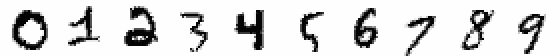

<DisplayHandle display_id=9921923a35e196ce242343200af1a468>

In [85]:
#Pick the sample images
sample = np.empty(shape=10).astype('uint8')
for i in range(0,10):
  sample[i] = np.where(y_train==i)[0][5]

image_batch = X_train[sample]
plot_sample( image_batch )
